Packages

In [104]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt

import os

In [107]:
input_file="20230411_SummerTerm23_Data_Challenge_Infineon_Data.csv"
date_column_name = 'reporting_time'
no_months = 30

# Loading of dataset
df_origin = pd.read_csv(input_file, parse_dates=['reporting_time'])

#delete discontinuing products
df_continue = df_origin[df_origin['reporting_time']=='2023-02-01T00:00:00.000Z']
df_continue_origin = df_origin[df_origin['product_name'].isin(df_continue['product_name'])].copy()

df_continue_origin['reporting_time'] = pd.to_datetime(df_continue_origin['reporting_time'], utc=True)
df_continue_origin['product_application'] = df_continue_origin['product_application'].fillna('nan')
df_continue_origin.set_index('reporting_time', inplace=True)

# sub_df = df_continue_origin
sub_df = df_continue_origin[df_continue_origin.groupby('product_name').product_name.transform('count')>=no_months].copy()


In [108]:
sub_df.product_application.unique()

array(['gelb', 'rot', 'blau'], dtype=object)

In [109]:
all_prod_names = list(sub_df['product_name'].unique())

df_clus = sub_df[['product_name', 'product_application', 'product_main_family', 'product_marketing_name', 'product_basic_type']].groupby('product_name').max().fillna('nan').reset_index().copy()

In [111]:
df_all_demand = pd.DataFrame()
my_set = set()
for name in all_prod_names:
    df_loop = sub_df[sub_df['product_name']==name].rename({'demand':name}, axis = 1)[name].copy()
    if np.sum(np.abs(df_loop)) != 0:
        df_all_demand = pd.concat((df_all_demand, df_loop), axis=1)
    # df_all_demand = pd.concat((df_all_demand, df_loop), axis=1)

df_all_demand = df_all_demand.tail(int(12))

In [112]:
len(list(df_all_demand.columns))

1088

In [113]:
len(df_all_demand.columns)
valid_prod = list(df_all_demand.columns)
df_clus = df_clus[df_clus['product_name'].isin(valid_prod)].copy()


In [114]:
from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMeanVariance

Elbow Method

https://colab.research.google.com/drive/1usNfL_8UUd15kz1oCeXlhz61CwcvOZxX?usp=sharing#scrollTo=y59wcFubA1as

In [115]:
df_all_demand_processed = TimeSeriesScalerMeanVariance().fit_transform(df_all_demand)

In [116]:
Sum_of_squared_distances = []

K = range(2, 13)

for k in K:
    print('loop', k)
    km = TimeSeriesKMeans(n_clusters=k,
                          n_init = 2,
                          metric = 'dtw',
                          verbose = False,
                          max_iter_barycenter = 10,
                          random_state = 0)
    km.fit(df_all_demand_processed)
    Sum_of_squared_distances.append(km.inertia_)

loop 2
loop 3
loop 4
loop 5
loop 6
loop 7
loop 8
loop 9
loop 10
loop 11
loop 12


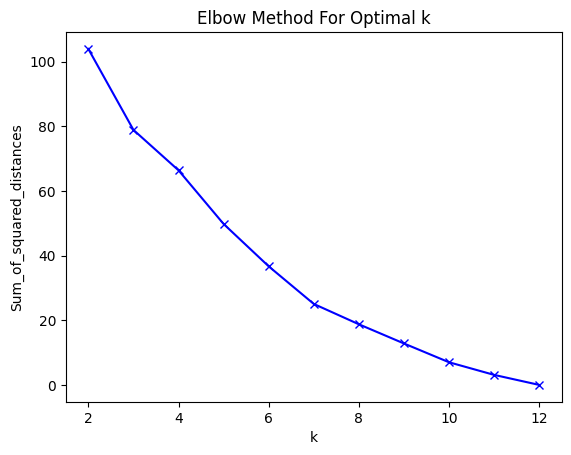

In [118]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [119]:
# according to the elbow method, we pick either 7 or 10 to be our number of clusters
# We now use silohuette score to determine which we should pick

km_7 = TimeSeriesKMeans(n_clusters=7,
                        n_init = 1,
                        metric = 'dtw',
                        verbose = False,
                        max_iter_barycenter = 10,
                        random_state = 0)
km_7.fit(df_all_demand_processed)

km_10 = TimeSeriesKMeans(n_clusters=10,
                         n_init = 1,
                         metric = 'dtw',
                         verbose = False,
                         max_iter_barycenter = 10,
                         random_state = 0)
km_10.fit(df_all_demand_processed)

TimeSeriesKMeans(max_iter_barycenter=10, metric='dtw', n_clusters=10,
                 random_state=0, verbose=False)

Silohuette score

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.decomposition import PCA
import matplotlib.cm as cm

In [ ]:
len(df_all_demand_processed)

12

In [22]:
n_cluster_list = [7, 10]

train_pca =  list(df_all_demand_processed.reshape(df_all_demand_processed.shape[1], df_all_demand_processed.shape[0]))
pca = PCA(n_components=len(df_all_demand))
train_pca = pca.fit_transform(train_pca)

In [23]:
len(train_pca[0])

12

c:\Users\melov\Documents\GitHub\tum_DAP_project\venv\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 7 The average silhouette_score is : 0.59


c:\Users\melov\Documents\GitHub\tum_DAP_project\venv\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


For n_clusters = 10 The average silhouette_score is : 0.53


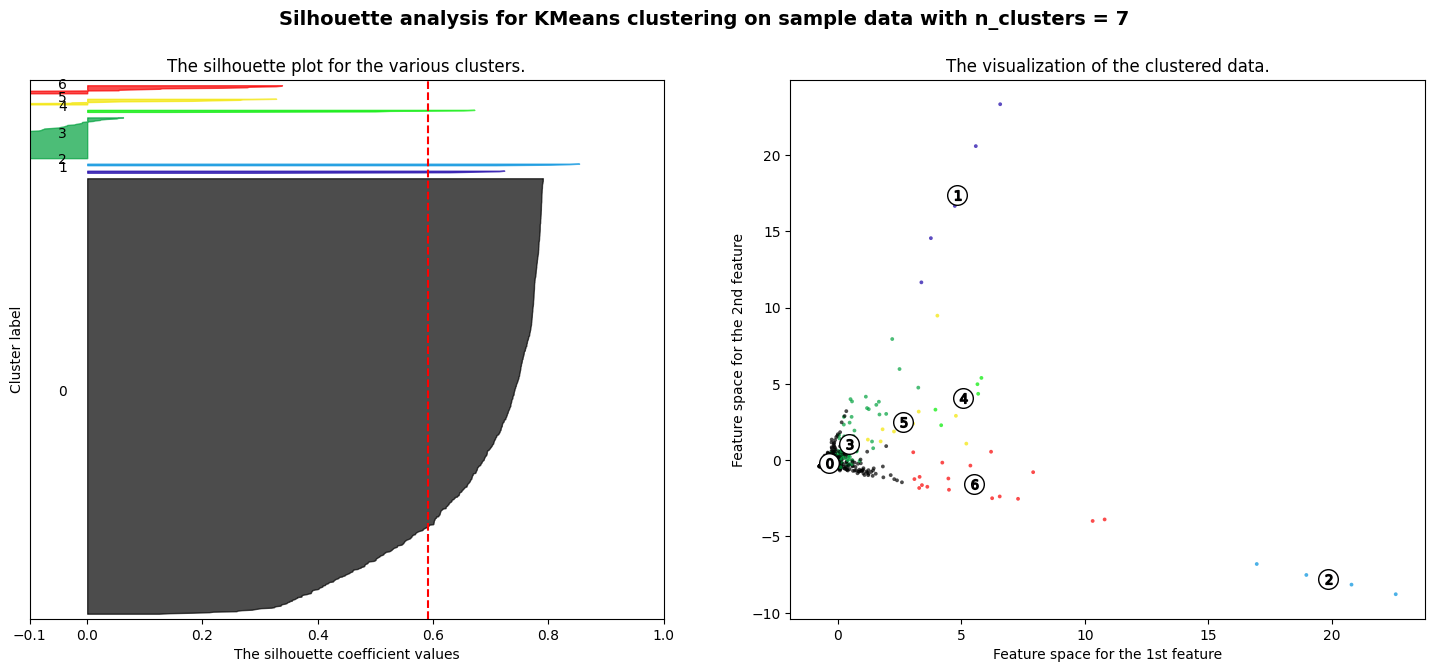

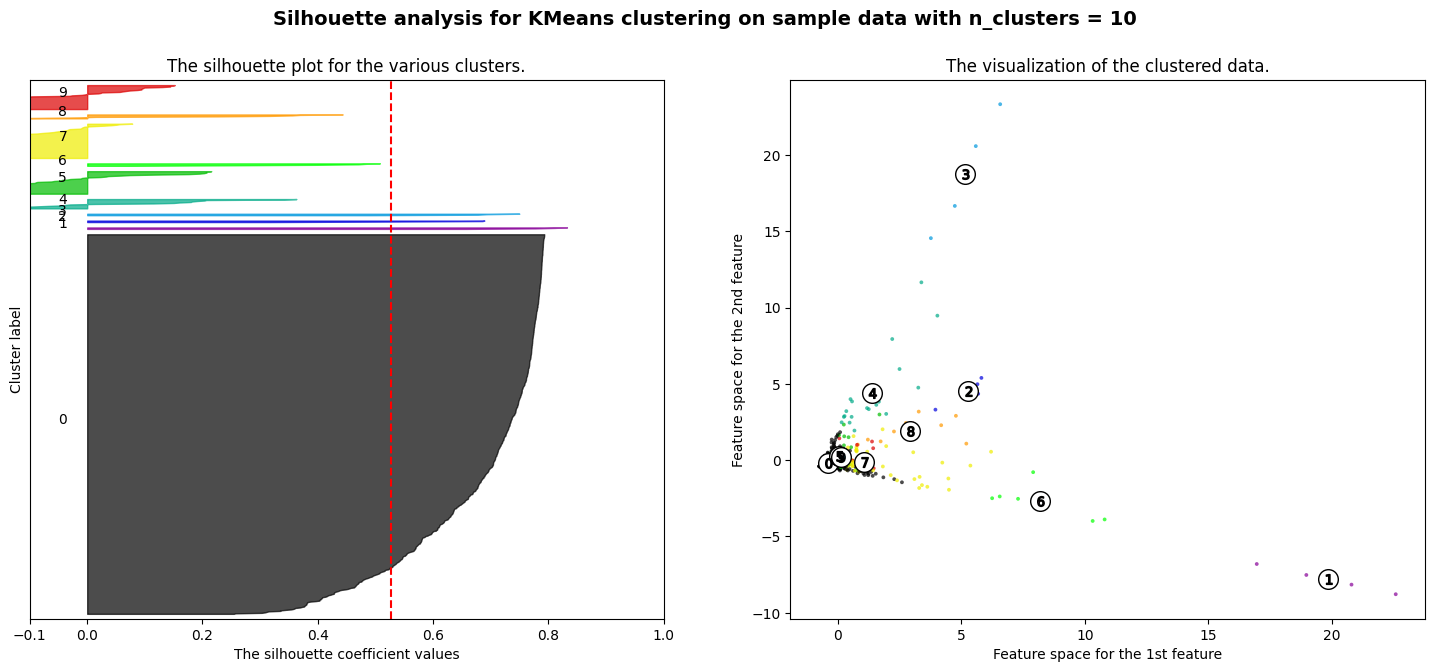

In [24]:
for clus in n_cluster_list:
    fig , (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18,7)
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(train_pca) + (clus + 1) * 10])
    cluster = KMeans(n_clusters=clus, random_state=0)
    cluster_labels = cluster.fit_predict(train_pca)
    silhouette_avg = silhouette_score(train_pca, cluster_labels)
    print("For n_clusters =",clus,"The average silhouette_score is : {:.2f}".format(silhouette_avg),)
    sample_silhouette_values = silhouette_samples(train_pca, cluster_labels)

    y_lower = 10
    for i in range(clus):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()

        
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / clus)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / clus)
    ax2.scatter(
        train_pca[:, 0], train_pca[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = cluster.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % clus,
        fontsize=14,
        fontweight="bold",
    )

plt.show()    

In [ ]:
df_all_demand_processed_2 = list(df_all_demand_processed.reshape(df_all_demand_processed.shape[1], df_all_demand_processed.shape[0]))
len(df_all_demand_processed_2)

1088

Euclidean k-means
Euclidean silhoutte: 0.57


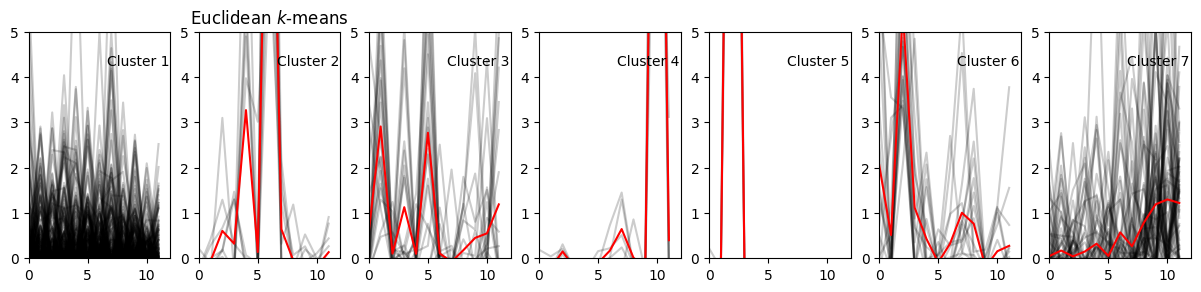

In [26]:
# Euclidean k-means

print("Euclidean k-means")
df_all_demand_processed_2 = df_all_demand_processed.reshape(df_all_demand_processed.shape[1], df_all_demand_processed.shape[0])
sz = len(df_all_demand_processed)
n_clusters= 7
km = TimeSeriesKMeans(n_clusters=n_clusters, verbose=False, random_state=0)
y_pred_km = km.fit_predict(df_all_demand_processed_2)


print("Euclidean silhoutte: {:.2f}".format(silhouette_score(df_all_demand_processed_2, y_pred_km, metric="euclidean")))

plt.figure(figsize=(15, 10))

for yi in range(n_clusters):
    plt.subplot(3, n_clusters, yi + 1)
    for xx in df_all_demand_processed_2[y_pred_km == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(km.cluster_centers_[yi].ravel(), "r-")
    plt.xlim(0, sz)
    plt.ylim(0, 5)
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("Euclidean $k$-means")

DBA k-means
DBA silhoutte: 0.52


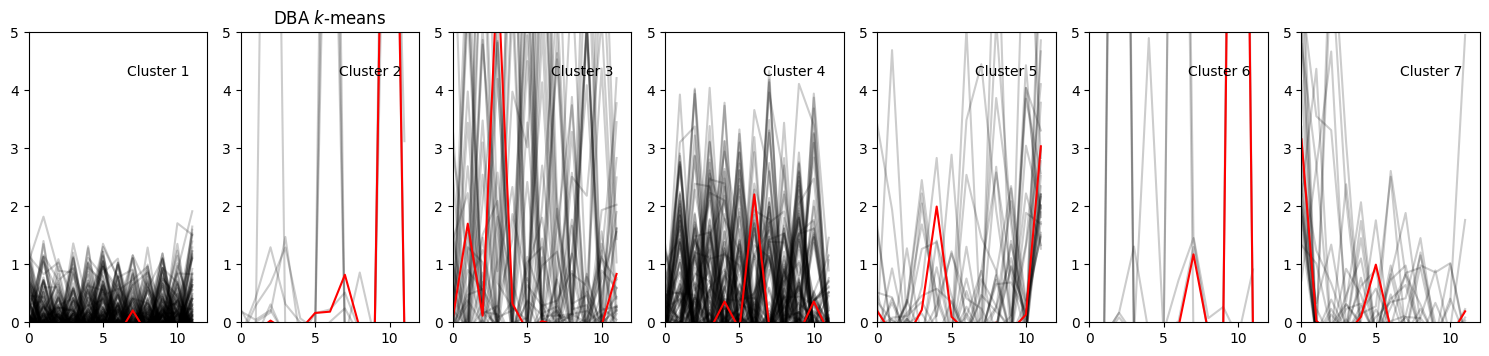

In [27]:
from tslearn.clustering import silhouette_score
print("DBA k-means")
dba_km = TimeSeriesKMeans(n_clusters=n_clusters,
                          n_init=2,
                          metric="dtw",
                          verbose=False,
                          max_iter_barycenter=10,
                          random_state=0)
y_pred_dba_km = dba_km.fit_predict(df_all_demand_processed_2)
print("DBA silhoutte: {:.2f}".format(silhouette_score(df_all_demand_processed_2, y_pred_dba_km, metric="dtw")))


plt.figure(figsize=(15, 10))
for yi in range(n_clusters):
    plt.subplot(3, n_clusters, yi+1)
    for xx in df_all_demand_processed_2[y_pred_dba_km == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(dba_km.cluster_centers_[yi].ravel(), "r-")
    plt.xlim(0, sz)
    plt.ylim(0, 5)
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("DBA $k$-means")
        


plt.tight_layout()
plt.show()

Euclidean k-means
Euclidean silhoutte: 0.53


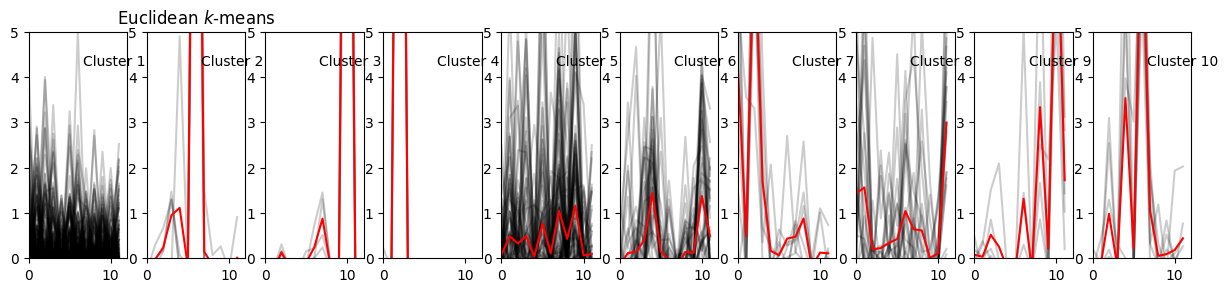

In [28]:
# with k = 10

# Euclidean k-means

print("Euclidean k-means")
df_all_demand_processed_2 = df_all_demand_processed.reshape(df_all_demand_processed.shape[1], df_all_demand_processed.shape[0])
sz = len(df_all_demand_processed)
n_clusters= 10
km = TimeSeriesKMeans(n_clusters=n_clusters, verbose=False, random_state=0)
y_pred_km = km.fit_predict(df_all_demand_processed_2)


print("Euclidean silhoutte: {:.2f}".format(silhouette_score(df_all_demand_processed_2, y_pred_km, metric="euclidean")))

plt.figure(figsize=(15, 10))

for yi in range(n_clusters):
    plt.subplot(3, n_clusters, yi + 1)
    for xx in df_all_demand_processed_2[y_pred_km == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(km.cluster_centers_[yi].ravel(), "r-")
    plt.xlim(0, sz)
    plt.ylim(0, 5)
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("Euclidean $k$-means")

DBA k-means
DBA silhoutte: 0.47


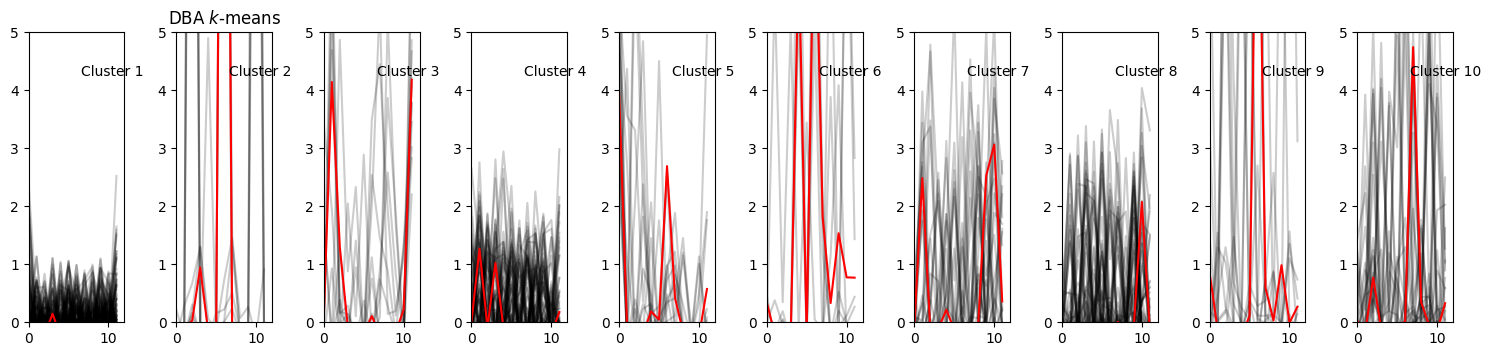

In [29]:
from tslearn.clustering import silhouette_score
print("DBA k-means")
dba_km = TimeSeriesKMeans(n_clusters=n_clusters,
                          n_init=2,
                          metric="dtw",
                          verbose=False,
                          max_iter_barycenter=10,
                          random_state=0)
y_pred_dba_km = dba_km.fit_predict(df_all_demand_processed_2)
print("DBA silhoutte: {:.2f}".format(silhouette_score(df_all_demand_processed_2, y_pred_dba_km, metric="dtw")))


plt.figure(figsize=(15, 10))
for yi in range(n_clusters):
    plt.subplot(3, n_clusters, yi+1)
    for xx in df_all_demand_processed_2[y_pred_dba_km == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(dba_km.cluster_centers_[yi].ravel(), "r-")
    plt.xlim(0, sz)
    plt.ylim(0, 5)
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("DBA $k$-means")
        


plt.tight_layout()
plt.show()

Euclidean k-means
Euclidean silhoutte: 0.53


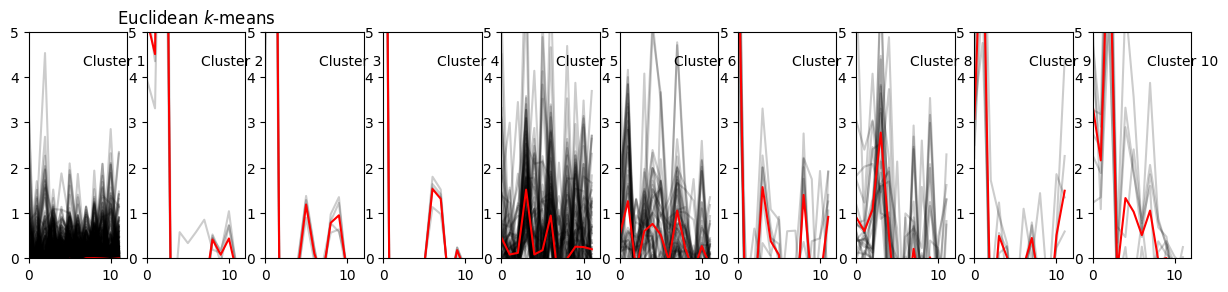

In [317]:
#using train_pca

print("Euclidean k-means")
# df_all_demand_processed_2 = df_all_demand_processed.reshape(df_all_demand_processed.shape[1], df_all_demand_processed.shape[0])
sz = len(train_pca[0])
n_clusters= 10
km = TimeSeriesKMeans(n_clusters=n_clusters, verbose=False, random_state=0)
y_pred_km = km.fit_predict(train_pca)


print("Euclidean silhoutte: {:.2f}".format(silhouette_score(train_pca, y_pred_km, metric="euclidean")))

plt.figure(figsize=(15, 10))

for yi in range(n_clusters):
    plt.subplot(3, n_clusters, yi + 1)
    for xx in train_pca[y_pred_km == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(km.cluster_centers_[yi].ravel(), "r-")
    plt.xlim(0, sz)
    plt.ylim(0, 5)
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("Euclidean $k$-means")

DBA k-means
DBA silhoutte: 0.43


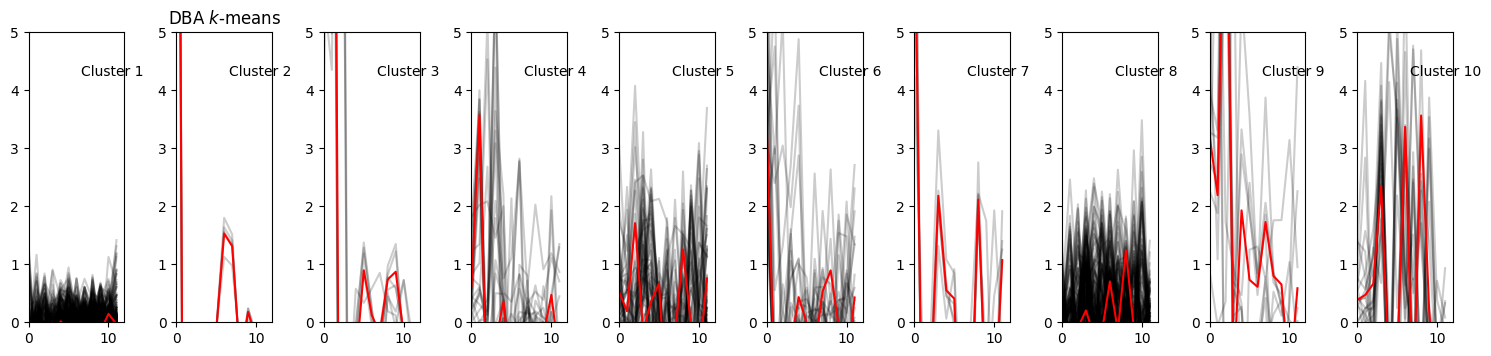

In [318]:
from tslearn.clustering import silhouette_score
print("DBA k-means")
dba_km = TimeSeriesKMeans(n_clusters=n_clusters,
                          n_init=2,
                          metric="dtw",
                          verbose=False,
                          max_iter_barycenter=10,
                          random_state=0)
y_pred_dba_km = dba_km.fit_predict(train_pca)
print("DBA silhoutte: {:.2f}".format(silhouette_score(train_pca, y_pred_dba_km, metric="dtw")))


plt.figure(figsize=(15, 10))
for yi in range(n_clusters):
    plt.subplot(3, n_clusters, yi+1)
    for xx in train_pca[y_pred_dba_km == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(dba_km.cluster_centers_[yi].ravel(), "r-")
    plt.xlim(0, sz)
    plt.ylim(0, 5)
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("DBA $k$-means")
        


plt.tight_layout()
plt.show()

# Clustering to find different groups of products

In [ ]:
# We choose k = 7 

km_7 = TimeSeriesKMeans(n_clusters=7,
                        n_init = 1,
                        metric = 'dtw',
                        verbose = False,
                        max_iter_barycenter = 10,
                        random_state = 0)
km_7.fit(df_all_demand_processed_2)

TimeSeriesKMeans(max_iter_barycenter=10, metric='dtw', n_clusters=7,
                 random_state=0, verbose=False)

In [ ]:
df_clus['cluster'] = km_7.labels_
# len(km_7.labels_)
sub_df = sub_df[sub_df['product_name'].isin(valid_prod)].copy()

In [ ]:
df_clus.product_application.unique()

array(['gelb', 'rot', 'blau'], dtype=object)

In [ ]:
df_clus.to_csv('cluster30.csv')

In [367]:
sub_df.head()

,product_name,demand,demand_lb,demand_ub,direct_demand_avg_perc,disti_demand_avg_perc,direct_customer_avg_count,disti_customer_avg_count,product_application,product_main_family,...,external4,external5,external6,external7,Open,High,Low,Close,Adj Close,Volume
reporting_time,,,,,,,,,,,,,,,,,,,,,
2018-09-01 00:00:00+00:00,P1000,93333.333333,40000.0,160000.0,0.0,100.0,0.0,5.0,gelb,E,...,-0.441068,-0.390011,-0.195539,0.288269,21.840000,21.950001,21.709999,21.910000,20.844067,1924085
2018-10-01 00:00:00+00:00,P1000,119375.000000,80000.0,222500.0,0.0,100.0,0.0,4.0,gelb,E,...,-0.481451,-0.331509,-0.254979,-0.481357,19.594999,20.139999,19.584999,19.990000,19.017475,4700125
2018-11-01 00:00:00+00:00,P1000,136000.000000,60000.0,255000.0,0.0,100.0,0.0,5.4,gelb,E,...,-0.930663,-0.448512,-0.359941,-0.365594,17.785000,18.420000,17.715000,18.330000,17.438234,9081213
2018-12-01 00:00:00+00:00,P1000,197500.000000,155000.0,272500.0,0.0,100.0,0.0,6.6,gelb,E,...,-0.992837,-0.565516,-0.530369,-0.551826,20.250000,20.250000,19.200001,19.200001,18.265911,12649523
2019-01-01 00:00:00+00:00,P1000,177500.000000,127500.0,240000.0,0.0,100.0,0.0,4.4,gelb,E,...,-1.048813,-0.448512,-0.644249,-0.527546,17.344999,17.485001,16.945000,17.389999,16.543966,4348505


In [373]:
# now we have df_clus and sub_df
# sub_df.head()
sub_df_clustered = sub_df.reset_index().merge(df_clus[['product_name','cluster']], on='product_name', how='left').set_index('reporting_time')

In [386]:
sub_df_clustered['unique_comb'] = sub_df_clustered['product_application'] + ", " + sub_df_clustered['product_basic_type'] + ', ' +sub_df_clustered['product_main_family'] + ', ' +sub_df_clustered['product_marketing_name']

In [429]:
df_clus['unique_comb'] = df_clus['product_application'] + ", " + df_clus['product_basic_type'] + ', ' +df_clus['product_main_family'] + ', ' +df_clus['product_marketing_name']

# df_clus['unique_comb'] = df_clus['product_application'] + ', ' +df_clus['product_main_family'] + ', ' +df_clus['product_marketing_name']

In [430]:
df_clus.unique_comb.value_counts()

gelb, BT344, A, katze    13
gelb, BT342, A, katze    13
gelb, BT343, A, katze    12
gelb, BT367, A, katze    11
gelb, BT345, A, katze    10
                         ..
blau, BT134, O, hund      1
gelb, BT252, E, hund      1
gelb, BT267, J, hund      1
gelb, BT78, F, hund       1
blau, BT155, N, katze     1
Name: unique_comb, Length: 344, dtype: int64

In [437]:
cluster_list = []
for i in range(7):
    combinations = list(df_clus[df_clus['cluster']==i]['unique_comb'].unique())
    cluster_list.append(combinations)

cluster_dict = {}
checked_set = set()
cluster_labs = [0, 1, 2, 3, 4, 5, 6]
for i in cluster_labs:
    temp_labs = cluster_labs.copy()
    print('checking cluster', i)
    result = set(cluster_list[i])
    temp_labs.pop(i)

    for s in temp_labs:
        
        if i**2 + s**2 in checked_set:
            continue
        checked_set.add(i**2+ s**2)
        if f'{i}+{s}' not in cluster_dict.keys():
            cluster_dict[f'{i}+{s}'] = set()
        result.intersection_update(cluster_list[s])
        for comb in result:
            cluster_dict[f'{i}+{s}'].add(comb)
        
        print(s)
        
        # if len(result)>0:
        #     print(result)
    cluster_dict[f'{i}+{s}'] = result
# result shows no intersections

checking cluster 0
1
2
3
4
5
6
checking cluster 1
2
3
4
5
6
checking cluster 2
3
4
5
6
checking cluster 3
5
6
checking cluster 4
5
6
checking cluster 5
6
checking cluster 6


In [438]:
# looking at overlapping combinations
cluster_dict

{'0+1': {'blau, BT329, G, katze',
  'blau, BT332, G, katze',
  'gelb, BT101, J, hund',
  'gelb, BT119, E, hund',
  'gelb, BT289, C, hund'},
 '0+2': {'blau, BT332, G, katze'},
 '0+3': {'blau, BT332, G, katze'},
 '0+4': {'blau, BT332, G, katze'},
 '0+5': set(),
 '0+6': set(),
 '1+2': {'blau, BT332, G, katze'},
 '1+3': {'blau, BT332, G, katze'},
 '1+4': {'blau, BT332, G, katze'},
 '1+5': set(),
 '1+6': set(),
 '2+3': {'blau, BT115, H, hund',
  'blau, BT116, D, hund',
  'blau, BT116, H, hund',
  'blau, BT162, F, hund',
  'blau, BT190, R, fisch',
  'blau, BT265, D, hund',
  'blau, BT304, G, katze',
  'blau, BT311, B, katze',
  'blau, BT316, B, katze',
  'blau, BT332, G, katze',
  'blau, BT338, A, katze',
  'gelb, BT124, D, hund',
  'gelb, BT124, E, hund',
  'gelb, BT124, H, hund',
  'gelb, BT129, C, hund',
  'gelb, BT272, D, hund',
  'gelb, BT342, A, katze',
  'gelb, BT343, A, katze',
  'gelb, BT345, A, katze',
  'gelb, BT353, A, katze',
  'gelb, BT367, A, katze',
  'gelb, BT370, A, katze',

In [428]:
len(checked_set)

20

https://dl.acm.org/doi/10.1145/3366424.3382728

https://towardsdatascience.com/cold-start-energy-predictions-d3971b1803e

https://drivendata.co/blog/benchmark-cold-start-lstm-deep-learning/